<div class="markdown-google-sans">

## **Badaga - English Translation Project**
## **mBART-50-mmt**
</div>

Installation

In [ ]:
!pip install transformers[torch] sentencepiece accelerate datasets sacrebleu

Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, load_metric
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

### Data Loading

In [ ]:
df = pd.read_excel('Badaga-v0.1.0.xlsx')
df.head()

,items,translated_transcript,audio_file_name,translterated_script,user_id,gender,locale,split_label,duration
0,1,what is the recipe in home,F002_1_1.mp3,manaya aena udhaka,F002,F,ba,train,2.377187
1,2,who is there near you,F002_1_2.mp3,pakka dhara edhdharae,F002,F,ba,train,2.377187
2,3,what did you prepare for lunch,F002_1_3.mp3,hagulu hasuga aena maditha,F002,F,ba,train,2.351062
3,4,did you brush,F002_1_4.mp3,hallu ujjithaya,F002,F,ba,train,2.194313
4,5,did you eat,F002_1_5.mp3,nee thindhubutaya,F002,F,ba,train,2.272687


In [ ]:
df.shape

(9837, 9)

In [ ]:
df.split_label.value_counts()

train         6897
validation    1470
test          1470
Name: split_label, dtype: int64

### Data Pre-processing

In [ ]:
# Dropping null values

df.dropna(inplace=True)
df.shape

(9834, 9)

In [ ]:
df.split_label.value_counts()

train         6895
validation    1470
test          1469
Name: split_label, dtype: int64

In [ ]:
# Splitting data into train, test and valid

train_df = df[df['split_label']=='train']
valid_df = df[df['split_label']=='validation']
test_df  = df[df['split_label']=='test']

In [ ]:
# Transforming Dataframes to pairs of translated(en) and transliterated text(ba)

def generate_pairs(df):
  eng = df['translated_transcript'].to_list()
  bad = df['translterated_script'].to_list()
  en_ba = []
  for i,j in zip(eng,bad):
    # en_ba.append({'translation':{}})
    en_ba.append({'en':i,'ba':j})
  return en_ba

train_pairs = generate_pairs(train_df)
valid_pairs = generate_pairs(valid_df)
test_pairs  = generate_pairs(test_df)

In [ ]:
train_pairs[0]

{'en': 'what is the recipe in home', 'ba': 'manaya aena udhaka'}

In [ ]:
# Generating new dataframes from dictionary pairs

new_train_df = pd.DataFrame({'translation':train_pairs})
new_train_df = new_train_df.reset_index(drop=True)
new_train_df.to_csv("translation_train.csv", sep="\t", encoding="utf-8", index=False)

new_valid_df = pd.DataFrame({'translation':valid_pairs})
new_valid_df = new_valid_df.reset_index(drop=True)
new_valid_df.to_csv("translation_valid.csv", sep="\t", encoding="utf-8", index=False)

new_test_df  = pd.DataFrame({'translation':test_pairs})
new_test_df  = new_test_df.reset_index(drop=True)
new_test_df.to_csv("translation_test.csv", sep="\t", encoding="utf-8", index=False)

In [ ]:
# Loading csv files in Dataset format

data_files = {
    "train": "translation_train.csv",
    "validation": "translation_valid.csv",
    "test": "translation_test.csv"
}

raw_datasets  = load_dataset("csv", data_files=data_files, delimiter="\t", )
metric = load_metric("sacrebleu")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(raw_datasets["train"])

,translation
0,"{'en': 'i have five hundred and five rupees', 'ba': 'aenna sarae hainoora haithu uripi hadathae'}"
1,"{'en': 'can you come', 'ba': 'baputhu mudatharava'}"
2,"{'en': 'you are too boring', 'ba': 'nee seriyana asundu thava'}"
3,"{'en': 'do you have a cap', 'ba': 'kovili hadathaya ninnna sarae'}"
4,"{'en': 'did you eat', 'ba': 'nee thindhubutaya'}"


In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 6895
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1470
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 1469
    })
})

In [ ]:
show_random_elements(raw_datasets["train"])

,translation
0,"{'en': 'this boy is so brilliant', 'ba': 'e koosu appara baevara'}"
1,"{'en': 'i have seen you when i was a kid', 'ba': 'na kunna koosa ebbannae ninnava noodithae'}"
2,"{'en': 'your socks is in the cupboard', 'ba': 'ninna maejoodu halamaari ogasu hadathae noodu'}"
3,"{'en': 'complete the work quickly and go home', 'ba': 'manakana gelchava berrikittu manaega ogu'}"
4,"{'en': 'i have a headache', 'ba': 'mandae eradhara aenaga'}"


### Model Loading: mBART-50

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

In [ ]:
max_input_length = 128
max_target_length = 128
source_lang = 'en'
target_lang = 'ba'
prefix = ""
import ast

def preprocess_function(examples):
    inputs = [ast.literal_eval(ex)[source_lang] for ex in examples["translation"]]
    targets = [ast.literal_eval(ex)[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    labels = tokenizer(targets, max_length=max_target_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
raw_datasets['train'][3562]

{'translation': "{'en': 'hullathi is my mothers village', 'ba': 'hullathi enna amma na hatti'}"}

In [ ]:
preprocess_function(raw_datasets['train'][3560:3562])

{'input_ids': [[250004, 6777, 398, 28219, 903, 2], [250004, 17, 15935, 18, 28219, 903, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]], 'labels': [[250004, 14610, 91134, 28, 21356, 7398, 99424, 3319, 2], [250004, 10, 33, 91134, 98, 21356, 7398, 34, 34530, 13, 2]]}

In [ ]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/6895 [00:00<?, ? examples/s]

Map:   0%|          | 0/1470 [00:00<?, ? examples/s]

Map:   0%|          | 0/1469 [00:00<?, ? examples/s]

In [ ]:
pip install accelerate -U

In [ ]:
from transformers import TrainingArguments

In [ ]:
!pip install transformers[torch]


In [ ]:
batch_size = 16

args = Seq2SeqTrainingArguments(
    "mbart_large_50_mmt_en-to-ba",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    save_steps=100,
    logging_steps=10,
    predict_with_generate=True,
    push_to_hub=False,
)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,0.925400,0.830600,52.257800,12.585000
2,0.245700,0.282424,80.650100,12.552400
3,0.123100,0.163979,91.417400,12.810900
4,0.058200,0.130180,94.061400,12.772100
5,0.033200,0.121186,96.102200,12.791800


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#sav

TrainOutput(global_step=2155, training_loss=0.5614854784617568, metrics={'train_runtime': 3979.3431, 'train_samples_per_second': 8.663, 'train_steps_per_second': 0.542, 'total_flos': 851904214253568.0, 'train_loss': 0.5614854784617568, 'epoch': 5.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/mbart-50-mmt-en-to-ba"

model.save_pretrained(path)
tokenizer.save_pretrained(path)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


('/content/drive/MyDrive/mbart-50-mmt-en-to-ba/tokenizer_config.json',
 '/content/drive/MyDrive/mbart-50-mmt-en-to-ba/special_tokens_map.json',
 '/content/drive/MyDrive/mbart-50-mmt-en-to-ba/sentencepiece.bpe.model',
 '/content/drive/MyDrive/mbart-50-mmt-en-to-ba/added_tokens.json',
 '/content/drive/MyDrive/mbart-50-mmt-en-to-ba/tokenizer.json')

In [ ]:
model_directory = '/content/drive/MyDrive/mbart-50-mmt-en-to-ba'

# Load tokenizer and model from local directory
tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = AutoModelForSeq2SeqLM.from_pretrained(model_directory)

In [ ]:
test_pairs

[{'en': 'lets see what is going to happen',
  'ba': 'nadatharava aenthu nooduva'},
 {'en': 'come to village i will tell something important',
  'ba': 'hatti ga ba baevara aegina'},
 {'en': 'ther is a little water in this bottle',
  'ba': 'ei putti ya osi neeru tha hadathae'},
 {'en': 'did you buy a new vechile', 'ba': 'osa bandi esithiya'},
 {'en': 'i buyed a new shirt', 'ba': 'na ondhu osa kamisu esithae'},
 {'en': 'still how much time is left', 'ba': 'ennu aesu jaama hadathae'},
 {'en': 'today i want to complete this', 'ba': 'edhu endhdhu beriki haputhu'},
 {'en': 'this is in your hands', 'ba': 'edhu ninna kai na tha hadathae'},
 {'en': 'bus should come fast', 'ba': 'bandi manakana bantharae sari'},
 {'en': 'honey is too  sweet', 'ba': 'jaenu appara seeya'},
 {'en': 'he likes simbu', 'ba': 'emaga simbu tha edathara'},
 {'en': 'he acts very well', 'ba': 'emma ollenge nadichina'},
 {'en': 'i am aslo a good actor', 'ba': 'naanu ollenge nadichinae'},
 {'en': 'you should also act well', '

In [ ]:
len(test_pairs)

1469

In [ ]:
test_pairs[0]['ba']

'nadatharava aenthu nooduva'

In [ ]:
import torch
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n=1
test_example = test_pairs[n]

true_ba = []
pred_ba = []

def preprocess_function(examples):
    inputs = examples["en"]
    model_inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True).to(device)
    return model_inputs


tokenized_test_dataset = new_test_df['translation'].map(preprocess_function)
model.to(device)
# Inference
model.eval()
with torch.no_grad():
      output = model.generate(**tokenized_test_dataset[n])
decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)
print("Original English Sentence:",test_example['en'])
print("Original Badaga Sentence:",test_example['ba'])
print("Predicted Badaga Sentence:", decoded_output[0])

Original English Sentence: come to village i will tell something important
Original Badaga Sentence: hatti ga ba baevara aegina
Predicted Badaga Sentence: hatti ga ba ba ba baevara aegina


In [ ]:
input_en = []
true_ba = []
pred_ba = []


model.eval()

for i in range(len(test_pairs)):
  print(i)
  test_example = test_pairs[i]
  with torch.no_grad():
    output = model.generate(**tokenized_test_dataset[i])
    decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)
    # print("Original English Sentence:",test_example['en'])
    # print("Original Badaga Sentence:",test_example['ba'])
    # print("Predicted Badaga Sentence:", decoded_output[0])
    input_en.append(test_example['en'])
    true_ba.append(test_example['ba'])
    pred_ba.append(decoded_output[0])

NameError: name 'model' is not defined

In [ ]:
mbart_res_enba = pd.DataFrame({'input_en':input_en,'true_ba':true_ba,'pred_ba':pred_ba})
mbart_res_enba

,input_en,true_ba,pred_ba
0,lets see what is going to happen,nadatharava aenthu nooduva,nadatharava aenthu nooduva
1,come to village i will tell something important,hatti ga ba baevara aegina,hatti ga ba ba ba baevara aegina
2,ther is a little water in this bottle,ei putti ya osi neeru tha hadathae,ei putti ya osi neeru tha hadathae
3,did you buy a new vechile,osa bandi esithiya,osa bandi esithiya
4,i buyed a new shirt,na ondhu osa kamisu esithae,na ondhu osa kamisu esithae
...,...,...,...
1464,which fruit you like the most,ninnaga aena hannu appara edathara,ninnaga aena hannu appara edathara
1465,i feel sleepy,aenaga orruku bapaningae hadathae,aenaga orruku bapaningae hadathae
1466,how many people are there in your house,ninga maennaya aesaga edhi,ninga maennaya aesaga edhi
1467,what is price for gold,chinna baellae aesaga vario,dhesaga baellae aesaga vario


In [ ]:
mbart_res_enba.to_csv('mbart_res_enba.csv')

In [ ]:
import sacrebleu

bleu_scores = [sacrebleu.raw_corpus_bleu([pred], [[true]]) for pred, true in zip(pred_ba, true_ba)]
bleu_scores_values = [score.score for score in bleu_scores]

# Compute average BLEU score
average_bleu_score = sum(bleu_scores_values) / len(bleu_scores_values)

print("Average BLEU Score:", average_bleu_score)

Average BLEU Score: 95.61734367863045


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.translate import meteor_score

# Tokenize hypotheses and references
tokenized_pred_ba = [pred.split() for pred in pred_ba]
tokenized_true_ba = [true.split() for true in true_ba]

# Calculate METEOR scores
meteor_scores = [meteor_score.meteor_score([true], pred) for pred, true in zip(tokenized_pred_ba, tokenized_true_ba)]

# Compute average METEOR score
average_meteor_score = sum(meteor_scores) / len(meteor_scores)

print("Average METEOR Score:", average_meteor_score)

Average METEOR Score: 0.9578069835954321


### Badaga to English Translation

In [ ]:
max_input_length = 128
max_target_length = 128
source_lang = 'ba'
target_lang = 'en'
prefix = ""
import ast
def preprocess_function(examples):
    inputs = [ast.literal_eval(ex)[source_lang] for ex in examples["translation"]]
    targets = [ast.literal_eval(ex)[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets

    labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/6895 [00:00<?, ? examples/s]

Map:   0%|          | 0/1470 [00:00<?, ? examples/s]

Map:   0%|          | 0/1469 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

In [ ]:
batch_size = 16

args = Seq2SeqTrainingArguments(
    "opus-mt-ba-en",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    save_steps=100,
    logging_steps=10,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,0.561200,0.488081,65.874400,8.618400
2,0.108900,0.187996,86.122700,8.698600
3,0.062500,0.127000,92.493200,8.754400
4,0.020500,0.106410,94.844600,8.782300
5,0.003700,0.105999,95.414200,8.803400


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#sav

TrainOutput(global_step=2155, training_loss=0.3504941404410346, metrics={'train_runtime': 3008.8782, 'train_samples_per_second': 11.458, 'train_steps_per_second': 0.716, 'total_flos': 1379443703758848.0, 'train_loss': 0.3504941404410346, 'epoch': 5.0})

In [ ]:
path = "/content/drive/MyDrive/mBART-50-MMT-ba-en"

model.save_pretrained(path)
tokenizer.save_pretrained(path)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200, 'early_stopping': True, 'num_beams': 5, 'forced_eos_token_id': 2}


('/content/drive/MyDrive/mBART-50-MMT-ba-en/tokenizer_config.json',
 '/content/drive/MyDrive/mBART-50-MMT-ba-en/special_tokens_map.json',
 '/content/drive/MyDrive/mBART-50-MMT-ba-en/sentencepiece.bpe.model',
 '/content/drive/MyDrive/mBART-50-MMT-ba-en/added_tokens.json',
 '/content/drive/MyDrive/mBART-50-MMT-ba-en/tokenizer.json')

In [ ]:
def preprocess_function(examples):
    inputs = examples["ba"]
    model_inputs = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True).to(device)  # Move tensors to the desired device
    return model_inputs

tokenized_test_dataset = new_test_df['translation'].map(preprocess_function)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
input_ba = []
true_en = []
pred_en = []


model.eval()

for i in range(len(test_pairs)):
  print(i)
  test_example = test_pairs[i]
  with torch.no_grad():
    output = model.generate(**tokenized_test_dataset[i])
    decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)
    # print("Original English Sentence:",test_example['en'])
    # print("Original Badaga Sentence:",test_example['ba'])
    # print("Predicted Badaga Sentence:", decoded_output[0])
    input_ba.append(test_example['ba'])
    true_en.append(test_example['en'])
    pred_en.append(decoded_output[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
mbart_res_baen = pd.DataFrame({'input_ba': input_ba, 'true_en': true_en, 'pred_en': pred_en})
mbart_res_baen

,input_ba,true_en,pred_en
0,nadatharava aenthu nooduva,lets see what is going to happen,lets see what will happen
1,hatti ga ba baevara aegina,come to village i will tell something important,come to village i will tell something important
2,ei putti ya osi neeru tha hadathae,ther is a little water in this bottle,ther is a little water in this bottle
3,osa bandi esithiya,did you buy a new vechile,did you buy a new vechile
4,na ondhu osa kamisu esithae,i buyed a new shirt,i buyed a new shirt
...,...,...,...
1464,ninnaga aena hannu appara edathara,which fruit you like the most,which fruit you like the most
1465,aenaga orruku bapaningae hadathae,i feel sleepy,i feel sleepy
1466,ninga maennaya aesaga edhi,how many people are there in your house,how many people are there in your house
1467,chinna baellae aesaga vario,what is price for gold,what is price for gold


In [ ]:
mbart_res_baen.to_csv('mbart_res_baen.csv')

In [ ]:
bleu_scores = [sacrebleu.raw_corpus_bleu([pred], [[true]]) for pred, true in zip(pred_en, true_en)]
bleu_scores_values = [score.score for score in bleu_scores]

# Compute average BLEU score
average_bleu_score = sum(bleu_scores_values) / len(bleu_scores_values)

print("Average BLEU Score:", average_bleu_score)

Average BLEU Score: 95.99769680123984


In [ ]:
tokenized_pred_en = [pred.split() for pred in pred_en]
tokenized_true_en = [true.split() for true in true_en]

# Calculate METEOR scores
meteor_scores = [meteor_score.meteor_score([true], pred) for pred, true in zip(tokenized_pred_en, tokenized_true_en)]

# Compute average METEOR score
average_meteor_score = sum(meteor_scores) / len(meteor_scores)

print("Average METEOR Score:", average_meteor_score)

Average METEOR Score: 0.9672719932029799


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
index=['mBART-50','mT5','MarianMT','FSMT']
bl = [0.95,0.57,0.82,0.81]
me = [0.95,0.63,0.86,0.85]
df = pd.DataFrame([bl,me],columns=['BLEU','METEOR'],index=index)
df

ValueError: 2 columns passed, passed data had 4 columns

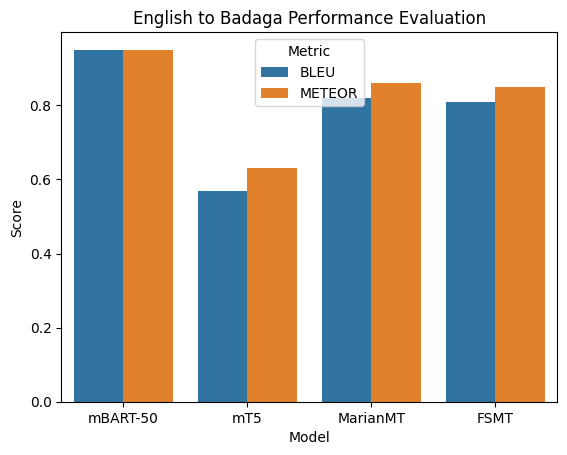

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data
index=['mBART-50', 'mT5', 'MarianMT', 'FSMT']
bl = [0.95, 0.57, 0.82, 0.81]
me = [0.95, 0.63, 0.86, 0.85]

# Creating DataFrame
df = pd.DataFrame({'Model': index * 2,
                   'Score': bl + me,
                   'Metric': ['BLEU'] * len(index) + ['METEOR'] * len(index)})

# Plotting
sns.barplot(x='Model', y='Score', hue='Metric', data=df,)
plt.title('English to Badaga Performance Evaluation')
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()

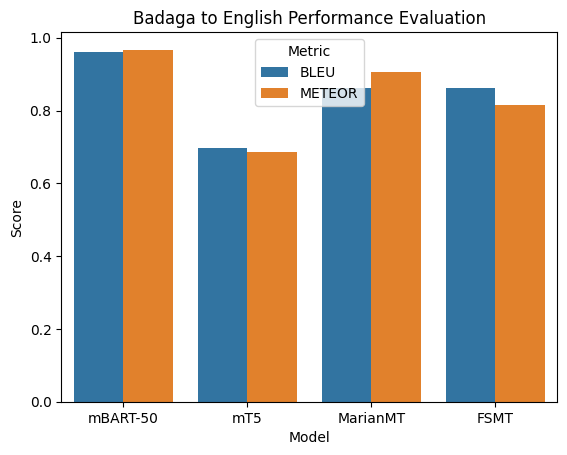

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data
index=['mBART-50', 'mT5', 'MarianMT', 'FSMT']
bl = [0.9599, 0.6983, 0.8627, 0.8611]
me = [0.9672, 0.6855, 0.9067, 0.8149]

# Creating DataFrame
df = pd.DataFrame({'Model': index * 2,
                   'Score': bl + me,
                   'Metric': ['BLEU'] * len(index) + ['METEOR'] * len(index)})

# Plotting
sns.barplot(x='Model', y='Score', hue='Metric', data=df,)
plt.title('Badaga to English Performance Evaluation')
plt.xlabel('Model')
plt.ylabel('Score')
plt.show()